Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [7]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.472707
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.120342
Minibatch accuracy: 56.2%
Validation accuracy: 60.6%
Minibatch loss at step 100: 0.745346
Minibatch accuracy: 68.8%
Validation accuracy: 70.3%
Minibatch loss at step 150: 1.268760
Minibatch accuracy: 62.5%
Validation accuracy: 74.6%
Minibatch loss at step 200: 1.070672
Minibatch accuracy: 68.8%
Validation accuracy: 76.4%
Minibatch loss at step 250: 0.372349
Minibatch accuracy: 93.8%
Validation accuracy: 78.6%
Minibatch loss at step 300: 0.547250
Minibatch accuracy: 87.5%
Validation accuracy: 79.9%
Minibatch loss at step 350: 0.685407
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 400: 0.350008
Minibatch accuracy: 93.8%
Validation accuracy: 79.6%
Minibatch loss at step 450: 0.986368
Minibatch accuracy: 68.8%
Validation accuracy: 80.6%
Minibatch loss at step 500: 1.052310
Minibatch accuracy: 62.5%
Validation accuracy: 81.0%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [37]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    hidden_mp = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(hidden_mp, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    hidden_mp = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape = hidden_mp.get_shape().as_list()
    reshape = tf.reshape(hidden_mp, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [38]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % ((num_steps-1)/5) == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.889923
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 200: 0.985547
Minibatch accuracy: 62.5%
Validation accuracy: 73.6%
Minibatch loss at step 400: 0.503540
Minibatch accuracy: 87.5%
Validation accuracy: 81.8%
Minibatch loss at step 600: 1.005453
Minibatch accuracy: 50.0%
Validation accuracy: 83.8%
Minibatch loss at step 800: 0.983238
Minibatch accuracy: 81.2%
Validation accuracy: 84.9%
Minibatch loss at step 1000: 0.282354
Minibatch accuracy: 93.8%
Validation accuracy: 85.5%
Test accuracy: 90.7%


---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [93]:
batch_size = 128
patch_size = 5
depth1 = 6
depth2 = 16
num_hidden1 = 120
num_hidden2 = 84

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))

  layer3_weights = tf.Variable(tf.truncated_normal([(image_size // 2 + 1 - patch_size) // 2 * (image_size // 2 + 1 - patch_size) // 2 * depth2, num_hidden1], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  layer5_weights = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    hidden_mp = tf.nn.dropout(tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'), 1)
    
    conv = tf.nn.conv2d(hidden_mp, layer2_weights, [1, 1, 1, 1], padding='VALID')
    hidden = tf.nn.relu(conv + layer2_biases)
    hidden_mp = tf.nn.dropout(tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME'), 1)
    
    shape = hidden_mp.get_shape().as_list()
    reshape = tf.reshape(hidden_mp, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases), 1)
    hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases), 1)
    return tf.matmul(hidden, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  regu = 0.001*(tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights))
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + regu)
    
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.05, global_step, 1, 0.9999)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 3.238901
Minibatch accuracy: 7.0%
Validation accuracy: 10.0%
Minibatch loss at step 200: 0.938955
Minibatch accuracy: 80.5%
Validation accuracy: 79.5%
Minibatch loss at step 400: 0.766176
Minibatch accuracy: 84.4%
Validation accuracy: 83.2%
Minibatch loss at step 600: 0.840778
Minibatch accuracy: 82.0%
Validation accuracy: 85.0%
Minibatch loss at step 800: 0.641068
Minibatch accuracy: 90.6%
Validation accuracy: 85.8%
Minibatch loss at step 1000: 0.639735
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Test accuracy: 91.8%


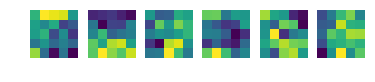

ValueError: Index out of range using input dim 2; input has only 2 dims for 'strided_slice_68' (op: 'StridedSlice') with input shapes: [150,16], [3], [3], [3].

In [120]:
num_steps = 1001
import matplotlib.pyplot as plt

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % ((num_steps-1)/5) == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

  shape = layer1_weights.get_shape().as_list()
  re_layer1_weights = tf.reshape(layer1_weights, [shape[0]*shape[1]*shape[2], shape[3]])
  fig = plt.figure()
  for index in range(6):
    layer1_conv = tf.reshape(re_layer1_weights[:,index], [5,5])
    subplot = fig.add_subplot(1,6, index+1)
    subplot.set_title('')
    plt.axis('off')
    plt.imshow(session.run(layer1_conv)) # display it
  plt.show()

  shape = layer2_weights.get_shape().as_list()
  re_layer2_weights = tf.reshape(layer2_weights, [shape[0]*shape[1]*shape[2], shape[3]])
  fig = plt.figure()
  for index in range(16):
    layer2_conv = tf.reshape(re_layer2_weights[:,0,index], [5,5])
    subplot = fig.add_subplot(1,16, index+1)
    subplot.set_title('')
    plt.axis('off')
    plt.imshow(session.run(layer2_conv)) # display it
  plt.show()
  